# Simulation MFD

In this tutorial we introduce a full demonstration of a simulation with `mnms` from the creation of the `MultiModalGraph` to a simulation run with the `MFDFlow` motor.
A quick demonstration of results analysis is also made at the end of the notebook.

## Simulation

### MultiModalGraph

In [1]:
from mnms.graph import MultiModalGraph
from mnms.graph.edition import walk_connect
from mnms.graph.generation import create_grid_graph
from mnms.mobility_service import BaseMobilityService

mmgraph = create_grid_graph(10, 5, 1000)
mmgraph.add_zone('ZONE', [l.id for l in mmgraph.flow_graph.links.values()])

car = BaseMobilityService('car', 10)
bus = BaseMobilityService('bus', 10) 

for n in mmgraph.flow_graph.nodes.keys():
    car.add_node('CAR_'+n, n)
    bus.add_node('BUS_'+n, n)

for l in mmgraph.flow_graph.links.values():
    uid = l.upstream_node
    did = l.downstream_node
    car.add_link('CAR_'+uid+'_'+did, 'CAR_'+uid, 'CAR_'+did, {'length': 1000, 'time':1000/car.default_speed}, [l.id])
    bus.add_link('BUS_' + uid + '_' + did, 'BUS_' + uid, 'BUS_' + did, {'length': 1000, 'time':1000/bus.default_speed}, [l.id])

mmgraph.add_mobility_service(car)
mmgraph.add_mobility_service(bus)
mmgraph.mobility_graph.check()

walk_connect(mmgraph, 1)

Walk |■■■■■■■■■■■■■■■■■■■■| 100 %


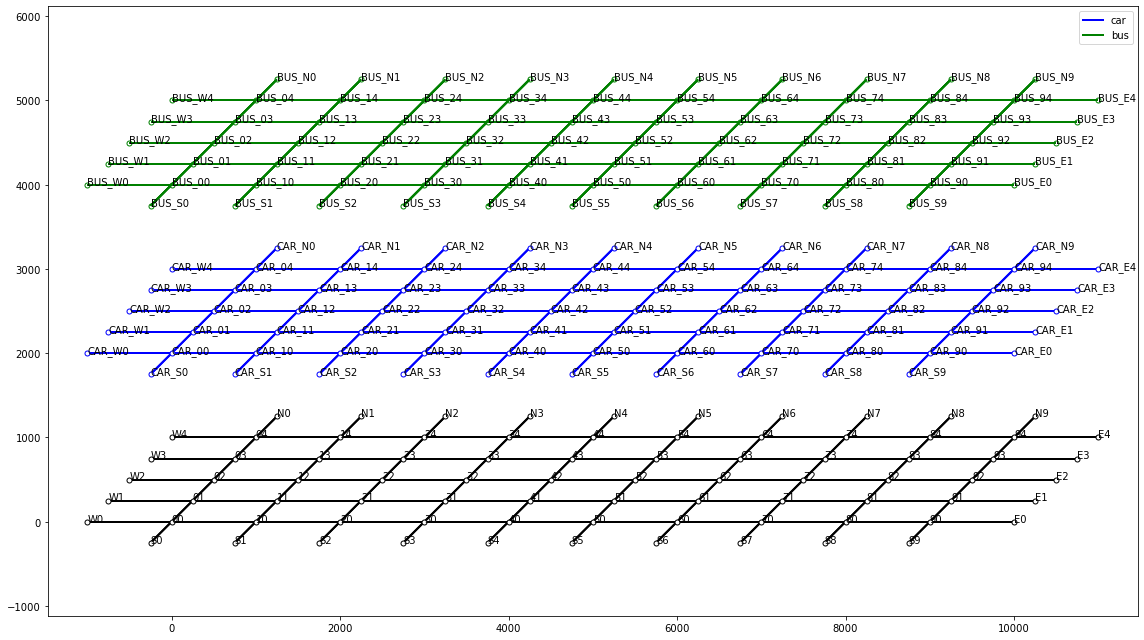

In [2]:
from mnms.tools.render import draw_multimodal_graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
draw_multimodal_graph(ax, mmgraph, nodesize=5, linkwidth=2, dy=2000)

### Demand

In [3]:
from mnms.demand.generation import create_random_demand

demand = create_random_demand(mmgraph, "07:00:00", "10:00:00", cost_path='length', min_cost=5000, seed=42)

### Travel decision model

In [4]:
from mnms.travel_decision import LogitDecisionModel
travel_decision = LogitDecisionModel(mmgraph, outfile="results/path.csv")

### Flow motor

In [5]:
from mnms.flow.MFD import Reservoir, MFDFlow

def res_fct(dict_accumulations):
    V_car = 11.5 * (1 - (dict_accumulations['car'] + dict_accumulations['bus']) / 500)
    V_car = max(V_car, 0.001)
    V_bus = V_car/2
    dict_speeds = {'car': V_car, 'bus': V_bus}
    return dict_speeds


reservoir = Reservoir.fromZone(mmgraph, 'ZONE', res_fct)

flow_motor = MFDFlow(outfile="results/flow.csv")
flow_motor.add_reservoir(reservoir)

### Supervisor

In [6]:
from mnms.simulation import Supervisor
from mnms.tools.time import Time, Dt

supervisor = Supervisor(graph=mmgraph,
                        flow_motor=flow_motor,
                        demand=demand,
                        decision_model=travel_decision,
                        outfile="results/travel_time_link.csv")

supervisor.run(Time('06:55:00'), 
               Time('10:20:00'), 
               Dt(minutes=1), 
               10)

## Result analysis

In [7]:
import pandas as pd

flow_result = pd.read_csv('results/flow.csv', sep=';')
flow_result

,AFFECTATION_STEP,FLOW_STEP,TIME,RESERVOIR,MODE,SPEED,ACCUMULATION
0,0,0,06:56:00.00,ZONE,car,11.50,0
1,0,0,06:56:00.00,ZONE,bus,5.75,0
2,0,1,06:57:00.00,ZONE,car,11.50,0
3,0,1,06:57:00.00,ZONE,bus,5.75,0
4,0,2,06:58:00.00,ZONE,car,11.50,0
...,...,...,...,...,...,...,...
415,20,207,10:23:00.00,ZONE,bus,5.75,0
416,20,208,10:24:00.00,ZONE,car,11.50,0
417,20,208,10:24:00.00,ZONE,bus,5.75,0
418,20,209,10:25:00.00,ZONE,car,11.50,0


In [8]:
flow_result_bus = flow_result[flow_result['MODE']=='bus']
flow_result_car = flow_result[flow_result['MODE']=='car']

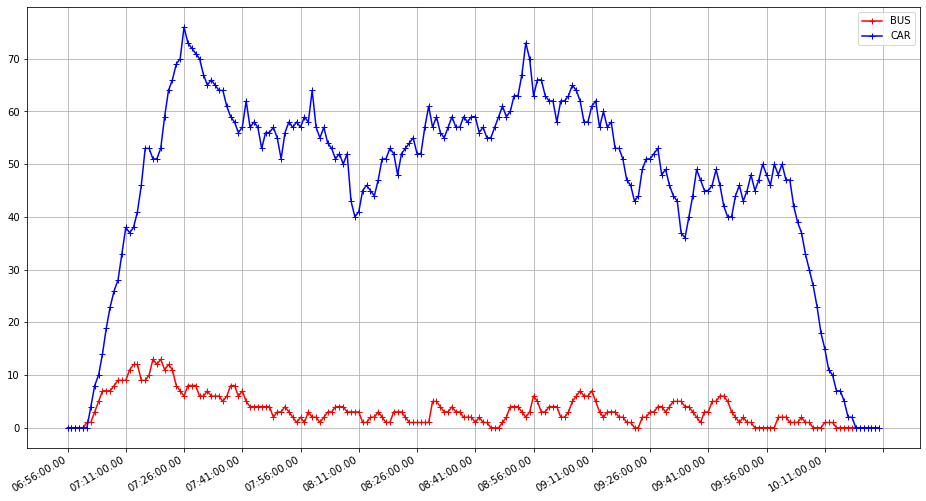

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(flow_result_bus['TIME'].to_list(), flow_result_bus['ACCUMULATION'].to_list(), 'r+-', label='BUS')
ax.plot(flow_result_car['TIME'].to_list(), flow_result_car['ACCUMULATION'].to_list(), 'b+-', label='CAR')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.grid()
plt.legend()
fig.autofmt_xdate()